## Style transfer

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

### install

In [2]:
#!tar -xvzf imagenet-sample-train.tar.gz
#!sudo pip3 install ../../old/
#!sudo pip3 install torchtext==0.2.3

### Import

In [1]:
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage
torch.cuda.set_device(0)

torch.backends.cudnn.benchmark=True

### Config

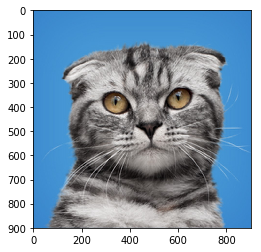

In [2]:
#!wget http://files.fast.ai/data/imagenet-sample-train.tar.gz
PATH = Path('data')
PATH_TRN = PATH/'train'

m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

img_fn = PATH/'pusefinn.jpg'
img = open_image(img_fn)
plt.imshow(img);

In [7]:
sz=500

In [8]:
trn_tfms,val_tfms = tfms_from_model(vgg16, sz)
img_tfm = val_tfms(img)
img_tfm.shape

(3, 800, 800)

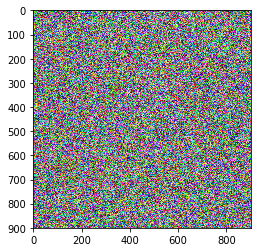

In [9]:
opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
plt.imshow(opt_img);

In [10]:
opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])

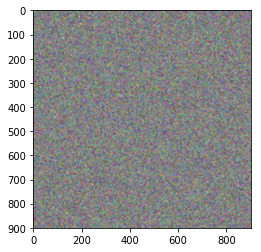

In [11]:
plt.imshow(opt_img);

In [12]:
opt_img = val_tfms(opt_img)/2
opt_img_v = V(opt_img[None], requires_grad=True)
opt_img_v.shape

torch.Size([1, 3, 800, 800])

In [14]:
m_vgg = nn.Sequential(*children(m_vgg)[:40])

In [15]:
targ_t = m_vgg(VV(img_tfm[None]))
targ_v = V(targ_t)
targ_t.shape

torch.Size([1, 512, 50, 50])

In [16]:
max_iter = 1000
show_iter = 100
optimizer = optim.LBFGS([opt_img_v], lr=0.5)

In [17]:
def actn_loss(x): return F.mse_loss(m_vgg(x), targ_v)*1000

In [18]:
def step(loss_fn):
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter+=1
    if n_iter%show_iter==0: print(f'Iteration: {n_iter}, loss: {loss.data[0]}')
    return loss

In [19]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,actn_loss))

Iteration: 100, loss: 0.4106517434120178
Iteration: 200, loss: 0.18352310359477997
Iteration: 300, loss: 0.11850764602422714
Iteration: 400, loss: 0.08886124938726425
Iteration: 500, loss: 0.07198330760002136
Iteration: 600, loss: 0.061123546212911606
Iteration: 700, loss: 0.05355279520153999
Iteration: 800, loss: 0.04805191606283188
Iteration: 900, loss: 0.04380273073911667
Iteration: 1000, loss: 0.04041645675897598


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


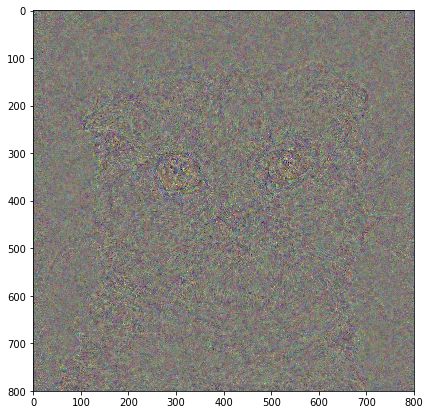

In [20]:
optimizer.step(partial(step,actn_loss))
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
plt.imshow(x);

## forward hook

In [21]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

In [22]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

In [23]:
block_ends = [i-1 for i,o in enumerate(children(m_vgg))
              if isinstance(o,nn.MaxPool2d)]
block_ends

[5, 12, 22, 32, 42]

In [24]:
sf = SaveFeatures(children(m_vgg)[block_ends[3]])

In [25]:
def get_opt():
    opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
    opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])
    opt_img_v = V(val_tfms(opt_img/2)[None], requires_grad=True)
    return opt_img_v, optim.LBFGS([opt_img_v])

In [26]:
opt_img_v, optimizer = get_opt()

In [27]:
m_vgg(VV(img_tfm[None]))
targ_v = V(sf.features.clone())
targ_v.shape

torch.Size([1, 512, 100, 100])

In [28]:
def actn_loss2(x):
    m_vgg(x)
    out = V(sf.features)
    return F.mse_loss(out, targ_v)*1000

In [29]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,actn_loss2))

Iteration: 100, loss: 0.2239958643913269
Iteration: 200, loss: 0.1094994843006134
Iteration: 300, loss: 0.0752158835530281
Iteration: 400, loss: 0.05903119221329689
Iteration: 500, loss: 0.049441251903772354
Iteration: 600, loss: 0.042992595583200455
Iteration: 700, loss: 0.038483526557683945
Iteration: 800, loss: 0.035116713494062424
Iteration: 900, loss: 0.03244733437895775
Iteration: 1000, loss: 0.030310144647955894


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


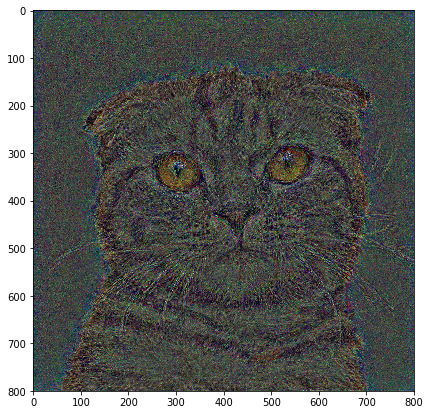

In [30]:

x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
plt.imshow(x);

In [31]:
sf.close()

## Style match

In [32]:
#!wget https://raw.githubusercontent.com/jeffxtang/fast-style-transfer/master/images/starry_night.jpg
style_fn = PATH/'style'/'starry_night.jpg'


In [33]:
style_img = open_image(style_fn)
style_img.shape, img.shape

((500, 800, 3), (900, 900, 3))

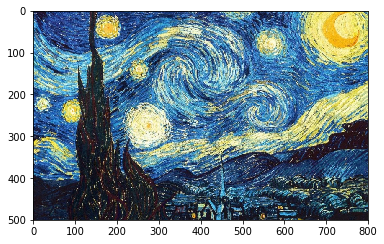

In [34]:
plt.imshow(style_img);

In [35]:
def scale_match(src, targ):
    h,w,_ = src.shape
    sh,sw,_ = targ.shape
    rat = max(h/sh,w/sw); rat
    res = cv2.resize(targ, (int(sw*rat), int(sh*rat)))
    return res[:h,:w]

In [36]:
style = scale_match(img, style_img)

((900, 900, 3), (900, 900, 3))

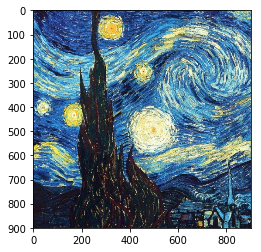

In [37]:
plt.imshow(style)
style.shape, img.shape

In [38]:
opt_img_v, optimizer = get_opt()

In [39]:
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

In [40]:
m_vgg(VV(img_tfm[None]))
targ_vs = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_vs]

[torch.Size([1, 64, 800, 800]),
 torch.Size([1, 128, 400, 400]),
 torch.Size([1, 256, 200, 200]),
 torch.Size([1, 512, 100, 100]),
 torch.Size([1, 512, 50, 50])]

In [41]:
style_tfm = val_tfms(style_img)

In [42]:
m_vgg(VV(style_tfm[None]))
targ_styles = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_styles]

[torch.Size([1, 64, 800, 800]),
 torch.Size([1, 128, 400, 400]),
 torch.Size([1, 256, 200, 200]),
 torch.Size([1, 512, 100, 100]),
 torch.Size([1, 512, 50, 50])]

In [43]:
def gram(input):
        b,c,h,w = input.size()
        x = input.view(b*c, -1)
        return torch.mm(x, x.t())/input.numel()*1e6

def gram_mse_loss(input, target): return F.mse_loss(gram(input), gram(target))

In [44]:
def style_loss(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    return sum(losses)

In [45]:
n_iter=0
max_iter= 1000
while n_iter <= max_iter: optimizer.step(partial(step,style_loss))

Iteration: 100, loss: 311.52154541015625
Iteration: 200, loss: 28.494632720947266
Iteration: 300, loss: 5.109718322753906
Iteration: 400, loss: 1.8606820106506348
Iteration: 500, loss: 1.00669527053833
Iteration: 600, loss: 0.6789593696594238
Iteration: 700, loss: 0.5120347142219543
Iteration: 800, loss: 0.4165095090866089
Iteration: 900, loss: 0.3563648462295532
Iteration: 1000, loss: 0.31575527787208557


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


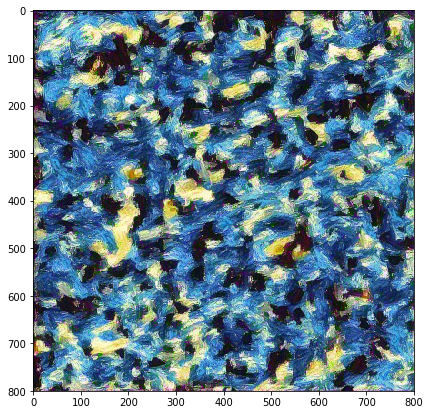

In [46]:
optimizer.step(partial(step,style_loss))
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
plt.imshow(x);



In [47]:
for sf in sfs: sf.close()

## Style transfer

In [56]:
opt_img_v, optimizer = get_opt()

In [57]:
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

In [58]:
def comb_loss(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    cnt_loss   = F.mse_loss(outs[3], targ_vs[3])*1000000
    style_loss = sum(losses)
    return cnt_loss + style_loss

In [59]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,comb_loss))

Iteration: 100, loss: 1560.136962890625
Iteration: 200, loss: 809.677978515625
Iteration: 300, loss: 571.9937133789062
Iteration: 400, loss: 463.43218994140625
Iteration: 500, loss: 406.03741455078125
Iteration: 600, loss: 372.26373291015625
Iteration: 700, loss: 349.96630859375
Iteration: 800, loss: 334.1168212890625
Iteration: 900, loss: 322.5361022949219
Iteration: 1000, loss: 313.3845520019531


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


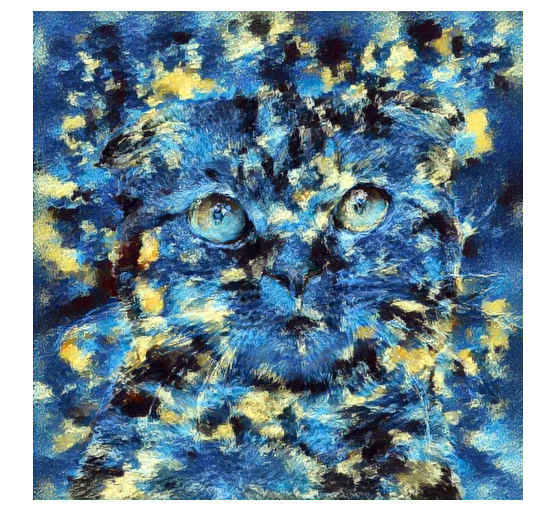

In [60]:
#optimizer.step(partial(step,comb_loss))
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(9,9))
plt.imshow(x, interpolation='lanczos')
plt.axis('off');

In [61]:
for sf in sfs: sf.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


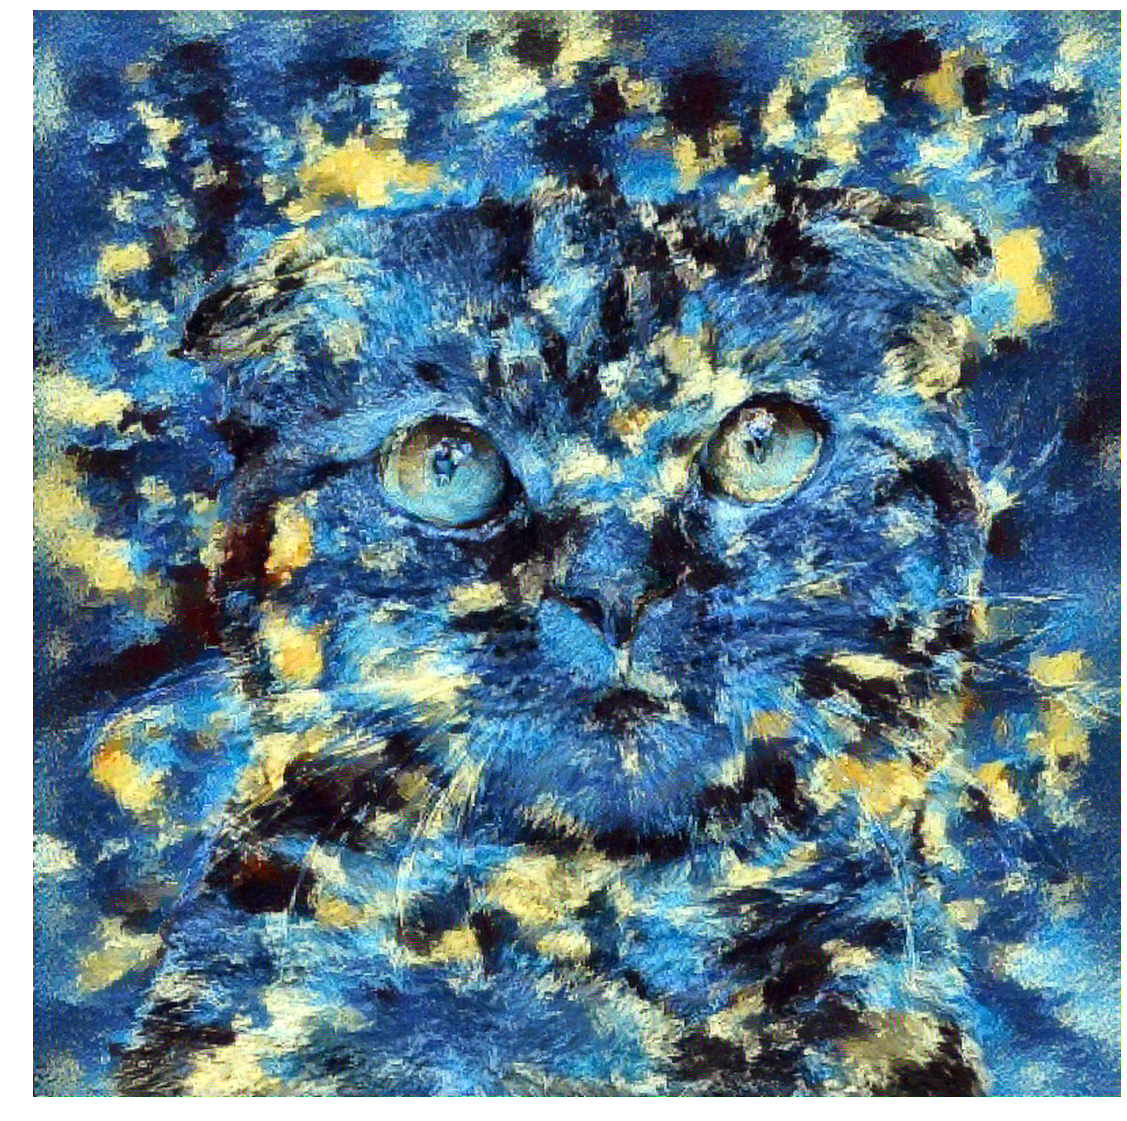

In [62]:
plt.figure(figsize=(20,20))
plt.imshow(x, interpolation='lanczos')
plt.axis('off');